In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

In [3]:
# TODO: run for all
dataset = 'tabula-muris-heart'
tool = 'seurat'
markers_path = "./results/{}/{}/markers.csv".format(dataset, tool)
data_path = "./dataset/{}-filtered/10X/".format(dataset)
labels_path = "./dataset/{}-filtered/labels.csv".format(dataset) # TODO:assuming no nan values
out_path = "./"

In [4]:
def apply_classifier(X, y):
    clf = RandomForestClassifier()
    y_pred = cross_val_predict(clf, X, y, cv=5)
    report = classification_report(y, y_pred, output_dict=True)
    clf.fit(X, y)
    return report, clf.feature_importances_

adata = sc.read_10x_mtx(
    data_path,
    var_names='gene_symbols',
    cache=False
)

In [5]:
markers_df = pd.read_csv(markers_path)
markers = markers_df.gene.unique()
n_markers = len(markers_df[markers_df['cluster']==1])
n_clusters = len(markers_df['cluster'].unique())

In [6]:
y_df = pd.read_csv(labels_path, index_col=0)
joined = pd.DataFrame(adata.obs_names, columns=["cell"]).join(y_df, on="cell")
mask = ~np.isnan(np.array(joined['cluster.ids'])).reshape(-1)
y = np.array(joined['cluster.ids'][mask])

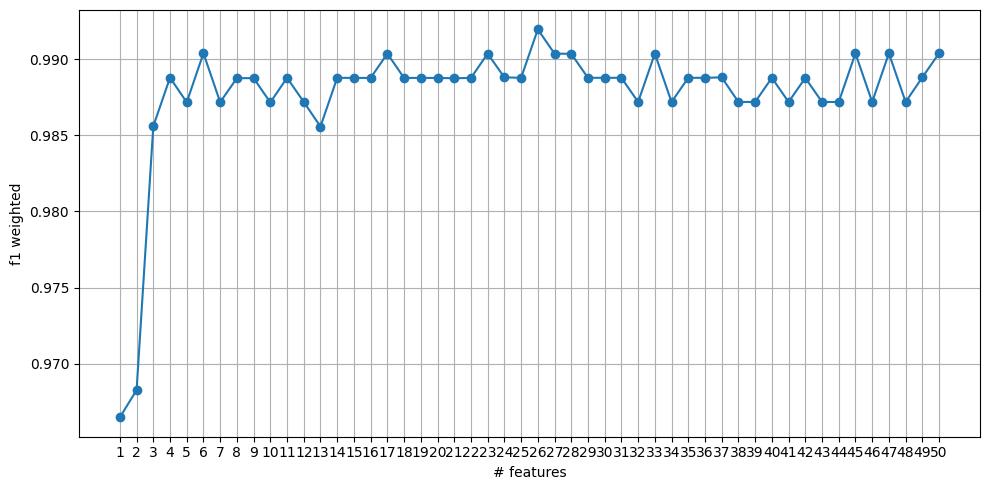

<Figure size 640x480 with 0 Axes>

In [7]:
# -------- train with increasing # of features taken from markers rank --------
scores = []
step = 1
score = 'f1-score'
for i in range(step, n_markers+step, step):
    top_markers = markers_df[markers_df['rank']<=i].gene.unique()
    X = adata[mask, top_markers].X.toarray()
    report, _ = apply_classifier(X, y)
    scores.append(report['weighted avg'][score])

x_ticks = [i for i in range(step, n_markers+step, step)]
x_ticks[-1] = n_markers
plt.figure(figsize=(10,5))
plt.xticks(x_ticks, x_ticks)
plt.plot(x_ticks, scores, marker='o')
plt.ylabel("f1 weighted")
plt.xlabel("# features")
plt.grid()
plt.tight_layout()
plt.show()
plt.savefig(out_path+"score.eps")

pd.DataFrame(scores, columns=['f1 weighted']).to_csv(out_path+"clf_score.csv")

In [ ]:
# -------- train on all features and on markers --------

X_all = adata[mask, :].X.toarray()
report_all, feature_importance = apply_classifier(X_all, y)
report_markers, _ = apply_classifier(adata[mask, markers].X.toarray(), y)

pd.DataFrame(report_all).transpose().to_csv(out_path+"clf_report_all.csv")
pd.DataFrame(report_markers).transpose().to_csv(out_path+"clf_report_markers.csv")

sorted_idx = (-feature_importance).argsort()
rf_features_sorted = adata.var_names[sorted_idx]
importaces_sorted = feature_importance[sorted_idx]
pd.DataFrame(
    {'genes' : rf_features_sorted, 'importaces' : importaces_sorted}
    ).to_csv(out_path+"importances.csv")

In [ ]:
# -------- select n_markers*n_clusters features with RFE and RF --------

selector = RFE(RandomForestClassifier(), n_features_to_select=n_markers*n_clusters, step=0.5)
selector.fit(X_all, y)
sorted_idx = (selector.ranking_).argsort()
rfe_features_sorted = adata.var_names[sorted_idx]
pd.DataFrame(
    {'genes' : rfe_features_sorted}
    ).to_csv(out_path+"rfe_ranking.csv")

# automatically choose the number of features
# rfe = RFECV(estimator=RandomForestClassifier())
# rfe.fit(X_all, y)
# rfe.show()

# TODO:
# - valutare intersezione
# - valutare bontà del ranking allenando con markers più in basso nella classifica?

# important_features = features_sorted[0:120]
# important_features = [f for f, i in zip(features_sorted, importaces_sorted) if i >= importaces_sorted[119]]
# intersection = set(markers).intersection(set(important_features))

#        rank di randomforest                  rank del tool
# gene1         100 *                         * 1 - (0-20)
# gene2         1 *                            
# gene3         1 *                            
# gene4         0 *                            